# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking-balanced/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics,
                      draw_sample_xy, draw_sample_rphi, draw_sample_rz)

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 14

## Load training results

Specify which results to load either by config file or training output directory.

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results_balanced')

In [6]:
ls $result_base

agnn_001/          scaling_agnn_n4/         scaling_cgpu_agnn_n2/
mpnn_001/          scaling_agnn_n64/        scaling_cgpu_agnn_n32/
scaling_agnn_n1/   scaling_agnn_n8/         scaling_cgpu_agnn_n4/
scaling_agnn_n16/  scaling_cgpu_agnn_n1/    scaling_cgpu_agnn_n64/
scaling_agnn_n2/   scaling_cgpu_agnn_n128/  scaling_cgpu_agnn_n8/
scaling_agnn_n32/  scaling_cgpu_agnn_n16/


In [7]:
result_name = 'agnn_001'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'balanced_sampler': True,
          'batch_size': 1,
          'data_buckets': 128,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_002',
          'n_train': 57344,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3},
 'model': {'hidden_activation': 'Tanh',
           'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_edge_layers': 4,
           'n_graph_iters': 8,
           'n_node_layers': 4,
           'name': 'agnn'},
 'n_ranks': 32,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 64,
                                      'factor': 0.1,
                                      'start_epoch': 32}],
               'name': 'Adam',
               'weight_decay': 1e-05},
 'output_dir': '/global/cscratch1/sd/sfarrell/heptrkx/results_balanced/agn

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.0010,0.400675,2873.099952,27.085263,0,109.843598,0.112088,0.952683,1.659703
1,0.0010,0.148592,2944.533815,27.684814,1,105.533394,0.075255,0.969748,1.570975
2,0.0010,0.110396,3015.678520,28.229230,2,108.026465,0.064810,0.975325,1.581695
3,0.0010,0.095092,3093.014693,28.746109,3,106.178978,0.063825,0.976263,1.843099
4,0.0010,0.088077,3170.145471,29.155788,4,107.213838,0.041615,0.985669,1.576474
...,...,...,...,...,...,...,...,...,...
59,0.0001,0.037563,3981.139143,31.827677,59,104.459384,0.020693,0.993961,2.711885
60,0.0001,0.037421,3975.403891,31.788607,60,104.013747,0.020786,0.993944,1.625537
61,0.0001,0.037312,3969.680270,31.750284,61,107.776388,0.021687,0.993678,1.650779
62,0.0001,0.037279,3964.181157,31.713037,62,104.058549,0.021450,0.993628,2.038198


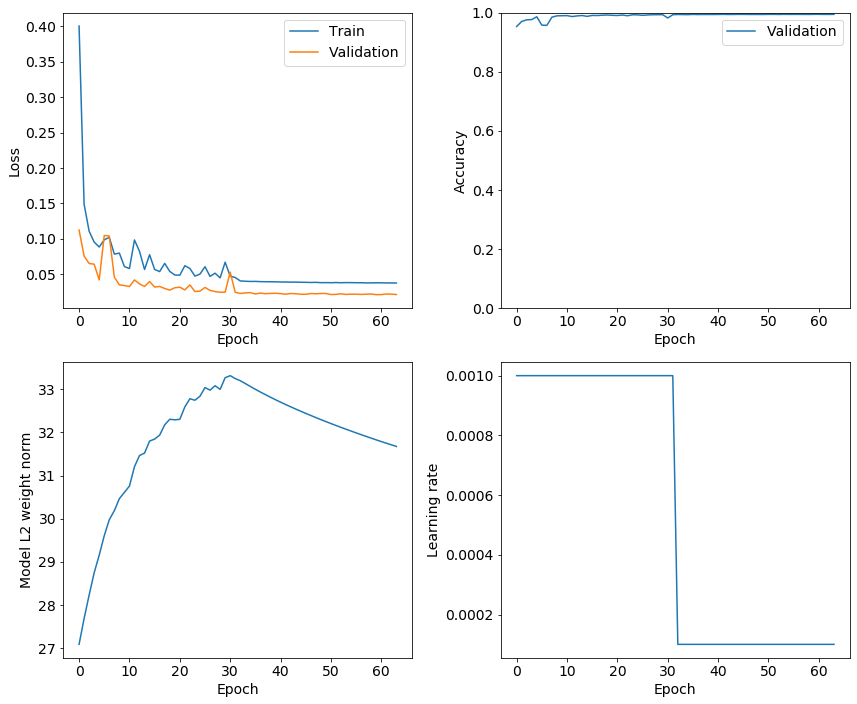

In [8]:
plot_train_history(summaries)

## Load the trained model

In [9]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin() #63
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
59,0.0001,0.037563,3981.139143,31.827677,59,104.459384,0.020693,0.993961,2.711885


In [10]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [11]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 24s, sys: 4.01 s, total: 1min 28s
Wall time: 22.9 s


In [13]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.5
Accuracy:  0.9941
Precision: 0.9587
Recall:    0.9590
F1 score:  0.9589


In [14]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.7
Accuracy:  0.9947
Precision: 0.9786
Recall:    0.9471
F1 score:  0.9626


In [15]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)
print('F1 score:  %.4f' % test_metrics.f1)

Test set results with threshold of 0.8
Accuracy:  0.9946
Precision: 0.9863
Recall:    0.9378
F1 score:  0.9615


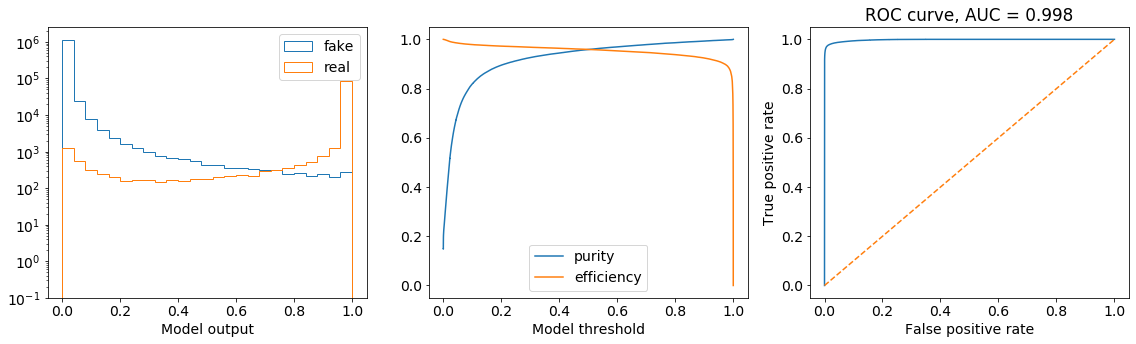

In [16]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [17]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [18]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

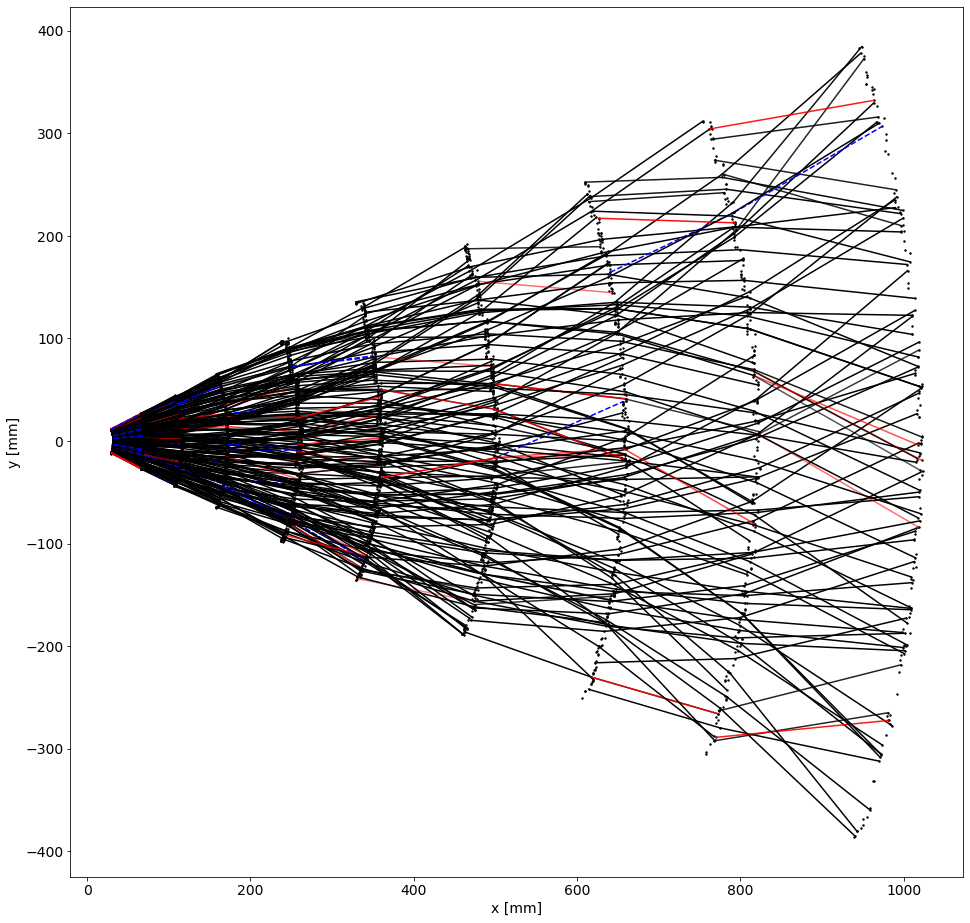

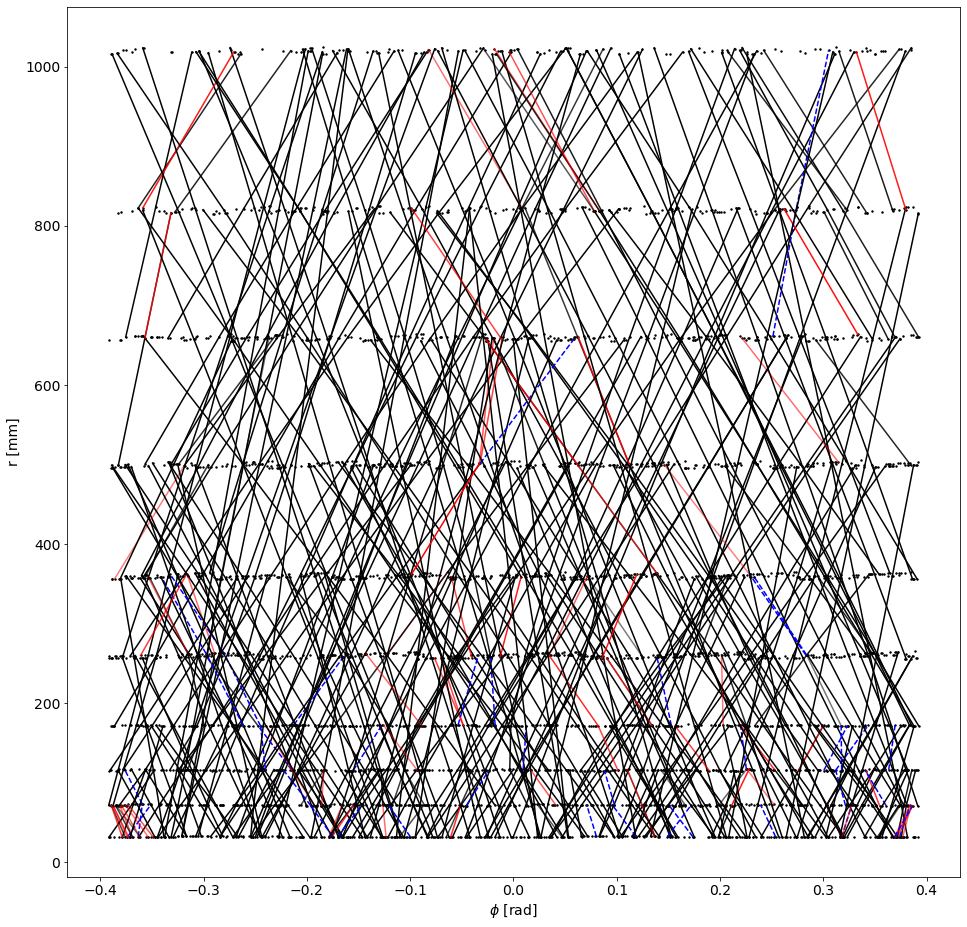

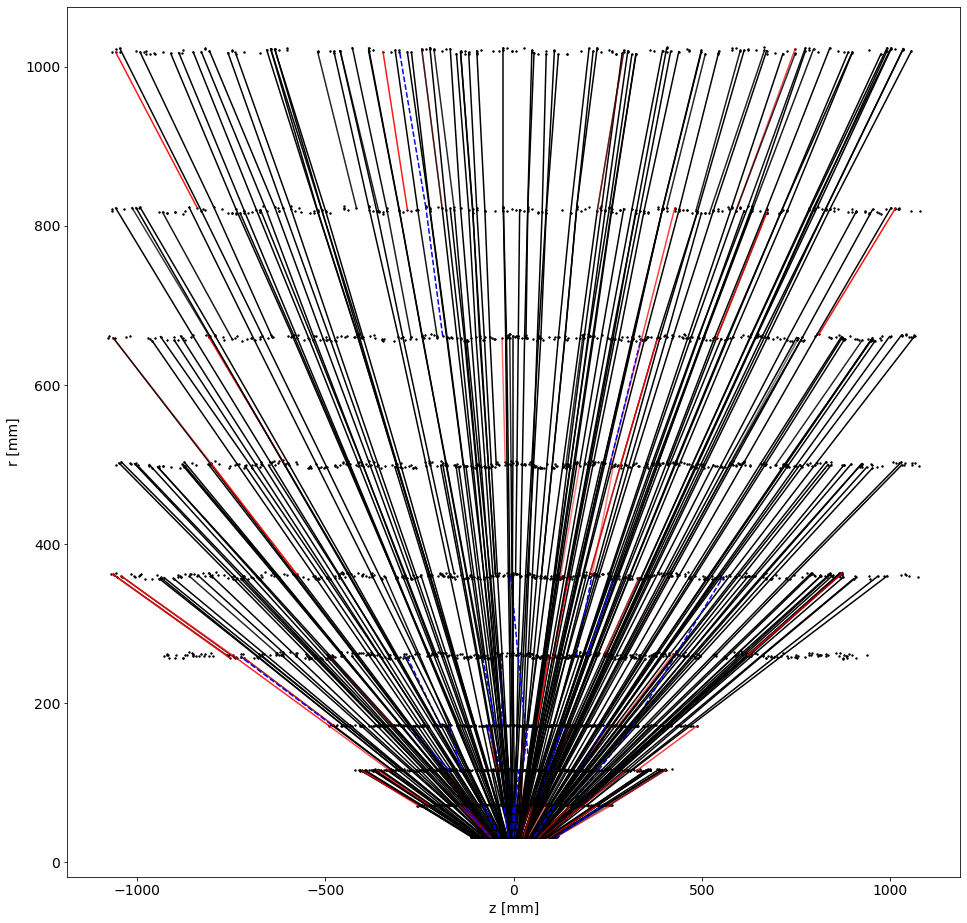

In [19]:
draw_cut = 0.5
draw_sample_xy(x, e, o, y, cut=draw_cut);
draw_sample_rphi(x, e, o, y, cut=draw_cut);
draw_sample_rz(x, e, o, y, cut=draw_cut);